#Installing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import keras
import tensorflow as tf

#Loading the Dataset

In [5]:
ipl = pd.read_csv('ipl_data.csv')
ipl.head()

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222
3,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.3,2,0,0,0,222
4,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.4,2,0,0,0,222


#Exploratory Data Analysis
###We will do Exploratory Data Analysis (EDA) to analyze how many unique matches have been played at each venue by counting distinct match IDs for every venue. Then, we’ll visualize this data using a horizontal bar chart to see which venues host the most matches

/tmp/ipython-input-65215632.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=matches_count.values, y=matches_count.index,palette="rainbow")


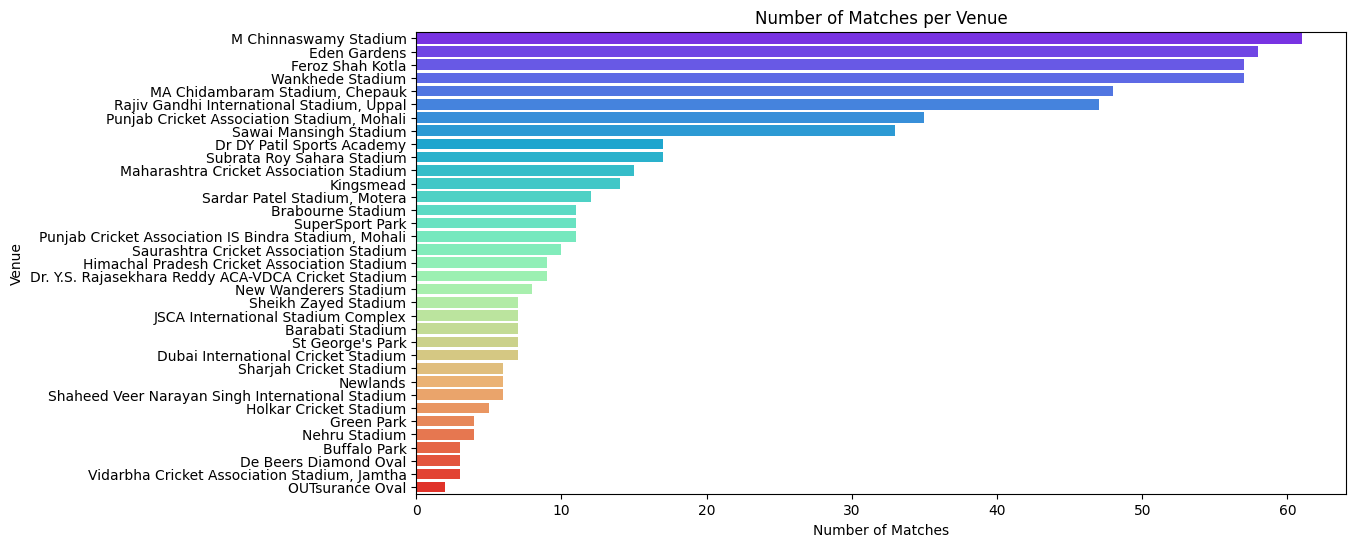

In [6]:
data = ipl.copy()
matches_per_venue = data[['mid', 'venue']].drop_duplicates()
matches_count = matches_per_venue['venue'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=matches_count.values, y=matches_count.index,palette="rainbow")
plt.title('Number of Matches per Venue')
plt.xlabel('Number of Matches')
plt.ylabel('Venue')
plt.show()

### Next we will calculate the maximum runs scored by each batsman by grouping the data by batsman their runs. Then we’ll identify the top 10 batsmen with the highest runs and display this information using a horizontal bar chart.

In [7]:
runs_by_batsman = data.groupby('batsman')['runs'].max().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

### Same thing do for bowler
### top 10 bowler for most wicket takers

/tmp/ipython-input-4069183659.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=wickets_by_bowlers.values,y=wickets_by_bowlers.index,palette='rainbow')


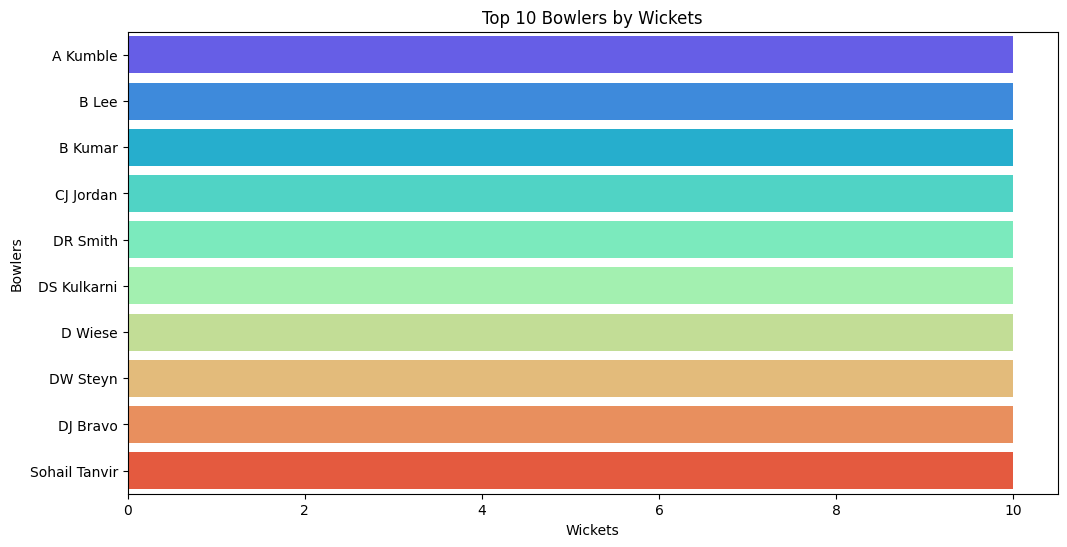

In [8]:
wickets_by_bowlers = data.groupby('bowler')['wickets'].max().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=wickets_by_bowlers.values,y=wickets_by_bowlers.index,palette='rainbow')
plt.title('Top 10 Bowlers by Wickets')
plt.xlabel('Wickets')
plt.ylabel('Bowlers')
plt.show()


#Performing Label Encoding
###We will convert categorical text data into numeric labels using Label Encoding because ML models work with numbers.

     ### LabelEncoder() converts text labels into integers.
     ### fit_transform() learns encoding and applies it.
     ### copy() : creates a duplicate of the DataFrame to avoid changing the original data
##A dictionary assignment stores each encoder for future use like decoding or consistent transformation

In [9]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['bat_team', 'bowl_team', 'venue', 'batsman', 'bowler']
data_encoded = data.copy()

label_encoders = {}

for col in cat_cols:
  le = LabelEncoder()
  data_encoded[col] = le.fit_transform(data_encoded[col])
  label_encoders[col] = le

# Performing Feature Selection


## We drop date and mid columns because they are identifiers and don’t provide meaningful information for correlation analysis. By removing these irrelevant columns we focus on features that can reveal relationships useful for modeling or insights. Computing and visualizing correlations helps identify which features are related and can guide feature selection.

### drop() : removes specified columns from the DataFrame
### corr() : computes pairwise correlations between numerical features
### sns.heatmap() : creates a colored matrix to visualize correlations with values
### plt.show() : displays the plot on screen

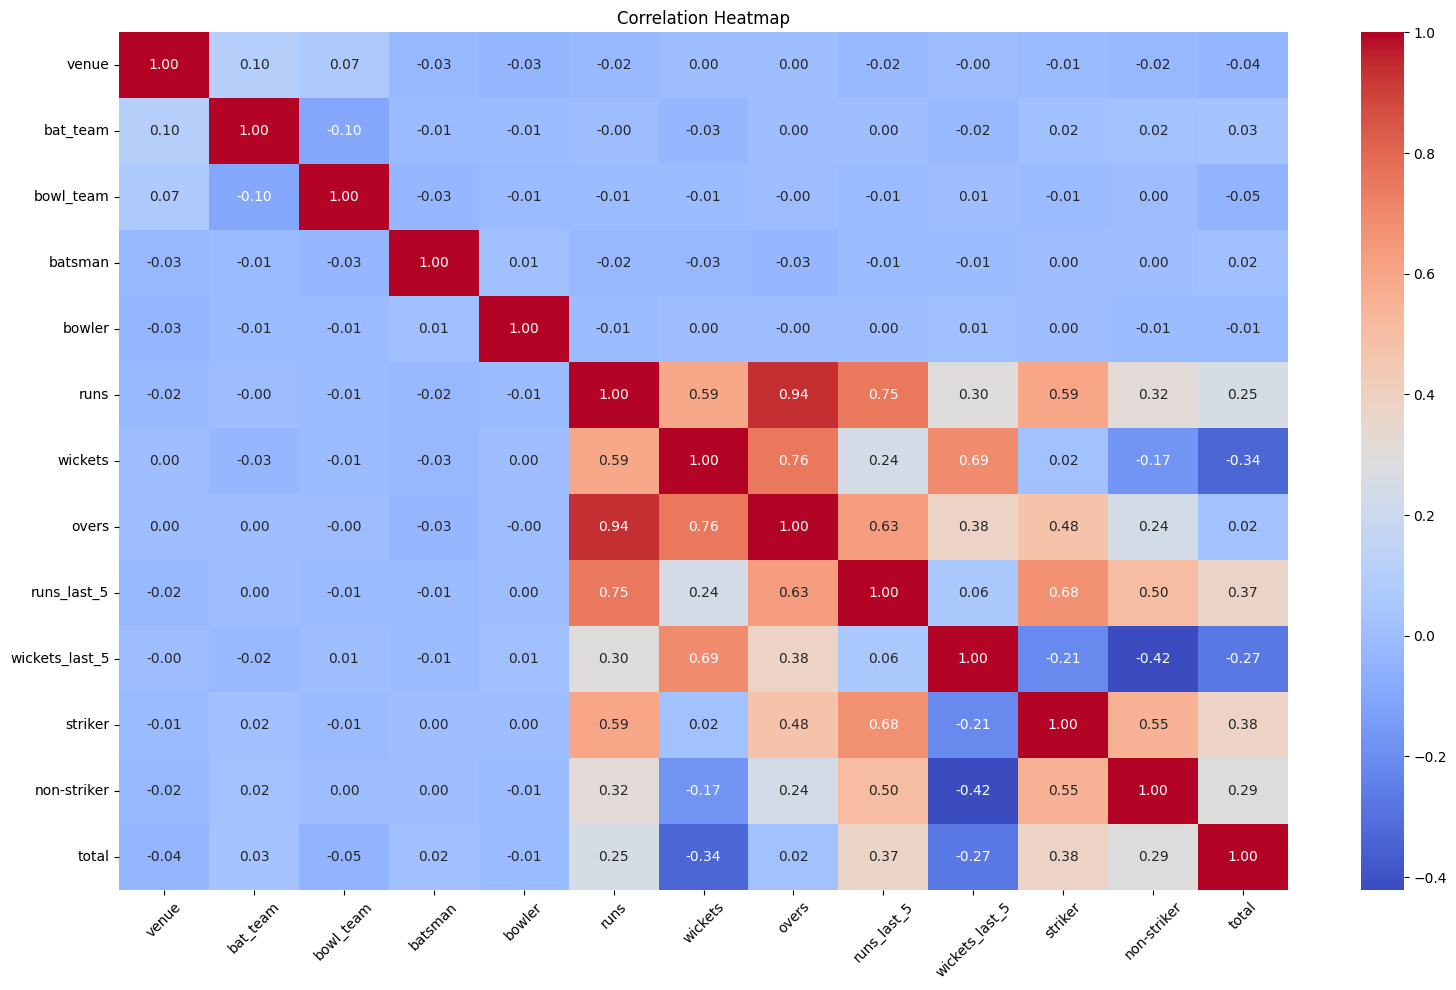

In [10]:
data_corr = data_encoded.drop(columns=["date", "mid"], axis=1)

plt.figure(figsize=(16, 10))  # width=16 inches, height=10 inches
sns.heatmap(data_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##Based on the heatmap we will drop the columns runs_last_5, wickets_last_5 and non-striker because they show high correlation with other features. Dropping highly correlated columns helps reduce redundancy and prevents multicollinearity which can improve model performance and interpretability.



#Splitting the dataset into Training and testing dataset

##We will select relevant features and the target variable then split the data into training and testing sets for model building and evaluation.

###DataFrame indexing (data_encoded[feature_cols]) : selects specified columns as features
###train_test_split() : splits features and target into training and test subsets
###test_size=0.3 : assigns 30% of data for testing
###random_state=42 : ensures reproducible splits by fixing the random seed





In [12]:
feature_cols = ['bat_team', 'bowl_team', 'venue', 'runs', 'wickets', 'overs', 'striker', 'batsman', 'bowler']

x = data_encoded[feature_cols]
y = data_encoded['total']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

#Feature Scalling
##We will perform Min-Max scaling on our input features to ensure all the features are on the same scale. It ensures consistent scale and improves model performance. Scaling will be done on both training and testing data using the scaling parameters.

###MinMaxScaler() scales features to [0,1] range.
###fit_transform() fits scaler on training data and transforms it.
###transform() applies same scaler to test data.

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Building the Neural Network

##We will build neural network using TensorFlow and Keras for regression. After building the model we have compiled the model using the Huber Loss because of the robustness of the regression against outliers.

### keras.Sequential() creates a stack of layers.
### Dense layers are fully connected layers.
### activation=relu adds non-linearity.
### Huber loss combines MSE and MAE advantages to handle outliers better.
### adam optimizer adjusts weights efficiently.





In [14]:
model = keras.Sequential([
    keras.layers.Input( shape=(x_train_scaled.shape[1],)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(216, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

huber_loss = tf.keras.losses.Huber(delta=1.0)  # You can adjust the 'delta' parameter as needed
model.compile(optimizer='adam', loss=huber_loss)

# Training the Model

# We train the model on the scaled training data for 10 epochs with a batch size of 64, validating on the test set.

### model.fit() trains the model.
### epochs=10 means the model sees the whole data 10 times.
### batch_size=64 updates weights after every 64 samples.
### validation_data evaluates model on test set during training.

In [15]:
model.fit(x_train_scaled, y_train, epochs=10, batch_size=64, validation_data=(x_test_scaled, y_test))

Epoch 1/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 52.3122 - val_loss: 14.9245
Epoch 2/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 15.2531 - val_loss: 14.2154
Epoch 3/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 14.7059 - val_loss: 15.8336
Epoch 4/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 14.5528 - val_loss: 14.2348
Epoch 5/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 14.3898 - val_loss: 14.2372
Epoch 6/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 14.3093 - val_loss: 13.8607
Epoch 7/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 14.2961 - val_loss: 14.2341
Epoch 8/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 14.2696 - val_loss: 13.8837
Epoch 9/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 14.2575 - val_loss: 13.7451
Epoch 10/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 14.2507 - val_loss: 13.8254


#We can plot the loss and validation loss of the model.

<Axes: >

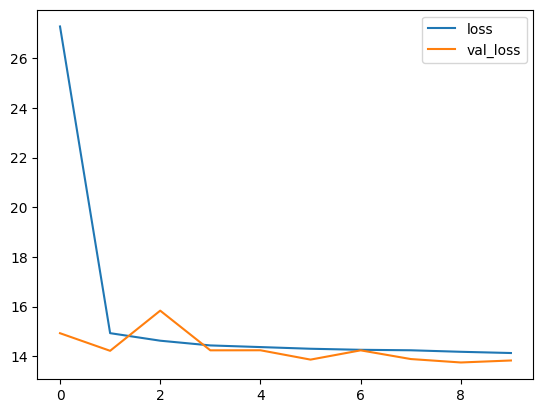

In [16]:
model_losses = pd.DataFrame(model.history.history)
model_losses.plot()

#Evaluating the Model
##We predict scores on test data and evaluate model performance using mean absolute error (MAE).

In [17]:
predictions = model.predict(x_test_scaled)

from sklearn.metrics import mean_absolute_error,mean_squared_error
mean_absolute_error(y_test,predictions)

713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


14.316049575805664

#Creating an Interactive Widget for Score Prediction
##We build an interactive interface using ipywidgets so users can select match details and get a live predicted score.

### widgets.Dropdown() creates dropdown menus.
### widgets.Button() creates a clickable button.
### predict_score() function handles user inputs, encodes and scales them, runs prediction and displays result.
### display() shows widgets in the notebook.




In [18]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings("ignore")

venue = widgets.Dropdown(options=list(label_encoders['venue'].classes_), description='Select Venue:')
venue.style = {'description_width': 'initial'}

batting_team = widgets.Dropdown(options=list(label_encoders['bat_team'].classes_), description='Select Batting Team:')
batting_team.style = {'description_width': 'initial'}

bowling_team = widgets.Dropdown(options=list(label_encoders['bowl_team'].classes_), description='Select Bowling Team:')
bowling_team.style = {'description_width': 'initial'}

striker = widgets.Dropdown(options=list(label_encoders['batsman'].classes_), description='Select Striker:')
striker.style = {'description_width': 'initial'}

bowler = widgets.Dropdown(options=list(label_encoders['bowler'].classes_), description='Select Bowler:')
bowler.style = {'description_width': 'initial'}

runs = widgets.IntText(value=0, description='Runs:', style={'description_width': 'initial'})
wickets = widgets.IntText(value=0, description='Wickets:', style={'description_width': 'initial'})
overs = widgets.FloatText(value=0.0, description='Overs:', style={'description_width': 'initial'})
striker_ind = widgets.IntText(value=0, description='Striker:', style={'description_width': 'initial'})  # Assuming 0 or 1
predict_button = widgets.Button(description="Predict Score")

output = widgets.Output()

def predict_score(b):
    with output:
        clear_output()  # Clear previous output

        encoded_venue = label_encoders['venue'].transform([venue.value])[0]
        encoded_batting_team = label_encoders['bat_team'].transform([batting_team.value])[0]
        encoded_bowling_team = label_encoders['bowl_team'].transform([bowling_team.value])[0]
        encoded_striker = label_encoders['batsman'].transform([striker.value])[0]
        encoded_bowler = label_encoders['bowler'].transform([bowler.value])[0]

        input_features = [
            encoded_batting_team,
            encoded_bowling_team,
            encoded_venue,
            runs.value,
            wickets.value,
            overs.value,
            striker_ind.value,
            encoded_striker,
            encoded_bowler
        ]

        input_array = np.array(input_features).reshape(1, -1)
        input_array = scaler.transform(input_array)
        predicted_score = model.predict(input_array)


        print(f"Predicted Total Runs: {int(predicted_score[0])}")

predict_button.on_click(predict_score)

display(venue, batting_team, bowling_team, striker, bowler,
        runs, wickets, overs,
        striker_ind,
        predict_button, output)

Dropdown(description='Select Venue:', options=('Barabati Stadium', 'Brabourne Stadium', 'Buffalo Park', 'De Be…

Dropdown(description='Select Batting Team:', options=('Chennai Super Kings', 'Deccan Chargers', 'Delhi Daredev…

Dropdown(description='Select Bowling Team:', options=('Chennai Super Kings', 'Deccan Chargers', 'Delhi Daredev…

Dropdown(description='Select Striker:', options=('A Ashish Reddy', 'A Chandila', 'A Chopra', 'A Choudhary', 'A…

Dropdown(description='Select Bowler:', options=('A Ashish Reddy', 'A Chandila', 'A Choudhary', 'A Flintoff', '…

IntText(value=0, description='Runs:', style=DescriptionStyle(description_width='initial'))

IntText(value=0, description='Wickets:', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.0, description='Overs:', style=DescriptionStyle(description_width='initial'))

IntText(value=0, description='Striker:', style=DescriptionStyle(description_width='initial'))

Button(description='Predict Score', style=ButtonStyle())

Output()